### Bogdan Bintu
### Copyright Presidents and Fellows of Harvard College, 2018.

### Standard analysis of the sample data
The sample data contains raw images from for region chr21:18.6Mb-20.6Mb in IMR90 cells for 6 cropped fields of view for the first 20 rounds of hybridization.

The subfolders H#R# indicate the hybrdization round and the index of the 30kb region imaged respectively.
Subfolder H0 contains DAPI signal and an imaged of the background before adding readout probes.

Each subfolder contains 6 cropped fields of view, each corresponding to a '.dax' file with the fluorescent signal recorded by the camera. This file format can be opened with tools in ChromatinImaging\CommonTools\IOTools.py

H0 is imaged in 3 colors: DAPI, cy3 (for fiducial beads) and cy5 (for readout signal)

H#R# are imaged in 2 colors: cy3 (for fiducial beads) and cy5 (for readout signal)

For each image a zstack is taken. 
The first 10 frames of the 3D image are to ensure the sample is in focus and should be ignored.
The piezo then moves the sample to the lowest z-position.
Each of the colors are imaged for any given z-position, then the z-position is incremented in steps of 200nm.



In [26]:
#External packages
import sys,glob,os
import numpy as np
import cPickle as pickle
import matplotlib.pylab as plt

#Internal packages
#add path
workbookDir = os.getcwd()
sys.path.append(os.path.dirname(workbookDir)+os.sep+'CommonTools')
#imports
import IOTools as io
import FittingTools as ft
import AlignmentTools as at
#for exmploring the data
import MaxViewer as mv


In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


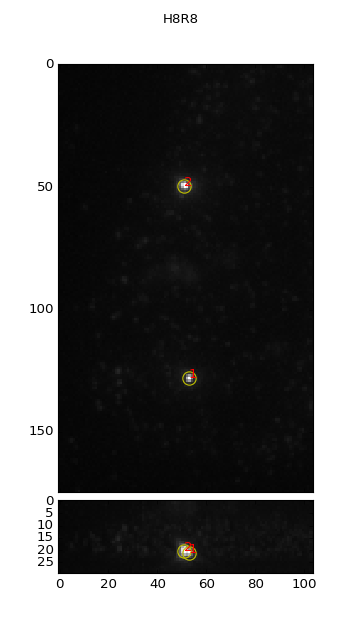

In [23]:
###Get file paths
master_folder = workbookDir+os.sep+'sample_data'

#get a list of hybe folders
folders = [folder for folder in glob.glob(master_folder+os.sep+'*') 
           if os.path.isdir(folder) and os.path.basename(folder)[0]=='H']
#sort them by the order they were hybed
def get_hybenumber(folder): return int(os.path.basename(folder).split('H')[-1].split('R')[0])
folders = np.array(folders)[np.argsort(map(get_hybenumber,folders))]
fovs = map(os.path.basename,glob.glob(folders[0]+os.sep+'*.dax'))

def get_ims_fov(folders,fov,verbose=True):
    """Given folders and a fov, this returns ims_signal,ims_beads,names"""
    ims_signal,ims_beads,names=[],[],[]
    for folder in folders:
        file__= folder+os.sep+fov
        tag=os.path.basename(folder)
        if os.path.exists(file__):
            names+=[os.path.basename(folder)]
            im = io.DaxReader(file__).loadMap()
            if tag!='H0':
                ims_beads += [im[10:-10][2::2]]
                ims_signal += [im[10:-10][1::2]]
            else:
                ims_beads += [im[10:-10][1::3]]
                ims_signal += [im[10:-10][2::3]]
    return  ims_signal,ims_beads,names

###Test for a fielf of view how the images look like.
#Please see the notebook in the CommonTools on how to use the tool

ims_signal,ims_beads,names=get_ims_fov(folders,fovs[0],verbose=True)

chroms = mv.imshow_mark_3d(ims_signal,image_names=names)
chroms.fast=True
chroms.th_seed=700

### Illumination can be flatten by efectively calculating the median value over many fields of view and dividing that value. 

### Ignore for this sample data.

In [42]:
#repair uneven illumination
analysis_folder = master_folder+os.sep+r'Analysis'
folder = folders[1]
ims_cy5=[]
ims_beads=[]
for file_ in fovs:
    file__= folder+os.sep+file_
    if os.path.exists(file__):
        im = tia.DaxReader(file__).loadMap()
        ims_beads += [np.median(im[10:-10][2::2],0)]
        ims_cy5 += [np.median(im[10:-10][1::2],0)]
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
im_cy5_repair = np.median(ims_cy5,0)
pickle.dump(im_cy5_repair,open(analysis_folder+os.sep+'im_cy5_repair.pkl','wb'))
im_beads_repair = np.median(ims_beads,0)
pickle.dump(im_beads_repair,open(analysis_folder+os.sep+'im_beads_repair.pkl','wb'))

### Rough align FOVs and get the mean across the hybes to select chromosomal positions

In [33]:
im_means=[]
analysis_folder = master_folder+os.sep+r'Analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
for fov_id,file_ in enumerate(fovs):
    print file_
    ims_cy5,ims_beads,names=[],[],[]
    for folder in folders[1:]:
        file__= folder+os.sep+file_
        if os.path.exists(file__):
            names+=[os.path.basename(folder)]
            im = io.DaxReader(file__).loadMap()
            ims_beads += [im[2::2][5:-5]]
            ims_cy5 += [im[1::2][5:-5]]
            #Above the bead and cy5 images would have been corrected for unevel illumination.
    ref=0
    ims_beads = [np.array(im,dtype=float) for im in ims_beads]
    
    xyz_roughs = map(lambda im: at.fftalign(ims_beads[ref],im,dm=40),ims_beads)
    xyz_roughs = -np.array(xyz_roughs)+[xyz_roughs[ref]]
    #print xyz_roughs
    ims_signal = map(lambda (im,xyz_rough): at.translate(im,-xyz_rough),zip(ims_cy5[:],xyz_roughs[:]))
    im_mean = np.mean(ims_signal,0)
    pickle.dump(np.array(im_mean,dtype=np.uint16),open(analysis_folder+os.sep+file_.replace('.dax','_mean.pkl'),'wb'))
    im_means+=[im_mean]

Conv_zscan_1.dax
Conv_zscan_2.dax
Conv_zscan_3.dax
Conv_zscan_4.dax
Conv_zscan_5.dax
Conv_zscan_6.dax


### Select the chromosomes using the MaxViewer tool

<IPython.core.display.Javascript object>


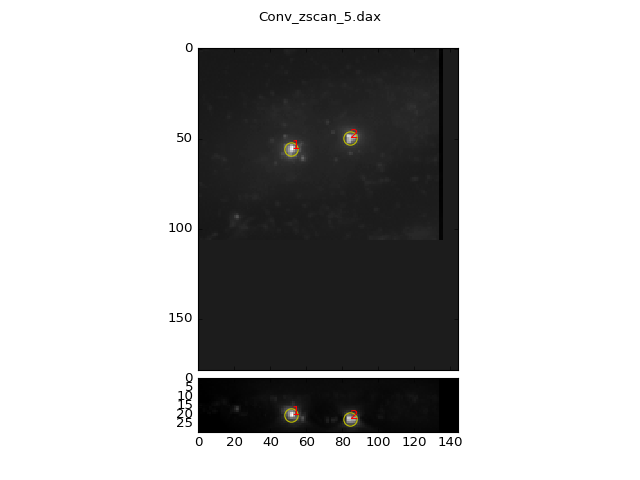

'Press A or D to move between fovs and press T to seed (maybe Y to fit) right click to select, Shift + right click to delete'

In [48]:
# make the fovs to the same dimensions
base = np.zeros(np.max([im.shape for im in im_means],0))
im_means_resc = []
for im in im_means:
    base_=base.copy()+np.median(im)
    base_[:im.shape[0],:im.shape[1],:im.shape[2]]=im
    im_means_resc.append(base_)
# Select and curate the chromosomes
chroms = mv.imshow_mark_3d(im_means_resc,image_names=fovs,save_file =analysis_folder+os.sep+'Selected_Spot.pkl')
chroms.fast=False
chroms.th_seed=400
chroms.gfilt_size=1
"Press A or D to move between fovs and press T to seed (maybe Y to fit) right click to select, Shift + right click to delete"

### Fit each fov in each hybe around the selected chromosomal positions and compile a list of candidate positions
### Perform drift correction for the candidate positions

In [53]:
##Load the chromosme data
dic = pickle.load(open(analysis_folder+os.sep+'Selected_Spot.pkl','r'))
chr_pts = ft.partition_map(dic['coords'],dic['class_ids'])
fov_ids = np.unique(dic['class_ids'])

In [ ]:

##where to save
analysis_folder = master_folder+os.sep+r'Analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

    
###paramaters
overwrite=False

#drift paramaters
ref=0 #drift reference hybe
sz_ex=30 #the effective size of the cube to do drift correction
hseed_beads=0 # The minimum bead height (prefitting)
nbeads = 50 # The maximum number of beads
force_drift=False

#brightness cutoffs
low_limit=150 #the minimum prefitting signal height
prefered_limit=300 #the initial try of prefitting signal height

#distance cutoffs
cutoff_window=20 #fitted points within this distance will be reported
cutoff_chr=10 #if no prefered brightness points are detected within this distance, then include low brightness ones



##RUN

from scipy.spatial.distance import cdist

#iterate through good fields of view for which chromosomes have been selected
folders_keep = list(folders[1:])
#itterate through fields of view
for ind in range(len(fov_ids))[:]:
    #Get selected chromosomal positions
    fov_id = fov_ids[ind]
    file_=fovs[fov_id]
    chr_pts_ = chr_pts[ind] #positions of the selected centers of chromosomes in reference frame.
    chr_pts_ = np.array(chr_pts_)[:,::-1]#zxy coords of chromosomes already in the right position
    
    #Decide where to save the candidate positions of the hybe
    fl_cands = analysis_folder+os.sep+file_.replace('.dax','__current_cand.pkl')#file where to save candidates
    fl_cor = analysis_folder+os.sep+file_.replace('.dax','__drift.pkl')#file where to save drift correction
    
    print fl_cands
    
    candid_spot={}
    #name for the hybes
    tags = [os.path.basename(folder) for folder in folders_keep]
    
    #load data (memory mapping)
    ims_beads=[]
    ims_cy5=[]
    tags = []
    for folder in folders_keep:
        file__= folder+os.sep+file_
        if os.path.exists(file__):
            tags.append(os.path.basename(folder))
            im = io.DaxReader(file__).loadMap()
            ims_beads += [im[2::2][5:-5]]
            ims_cy5 += [im[1::2][5:-5]]

    #compute the drift for the field of view
    if len(ims_beads)>1:
        txyz_both,_ = ft.get_STD_beaddrift(ims_beads,sz_ex=sz_ex,hseed=hseed_beads,nseed=nbeads,ref=None,force=force_drift,save_file=fl_cor)
        txyz = np.mean(txyz_both,1)
        txyz = np.array(txyz)-[txyz[ref]]

    #iterate through folders
    for iim in range(len(ims_cy5)):
        #iim specific vars
        im=ims_cy5[iim]
        tag = tags[iim]
        
        txyz_ = txyz[iim]
        #correct for illumination - ignore fo the sample_data
        #im=np.array(im,dtype=float)/im_cy5_repair*np.median(im_cy5_repair)
        
        #fit and update dictionary
        print tag
        ft.update_candid_spot(im,low_limit,prefered_limit,chr_pts_,txyz_,tag,
                       cutoff_window,cutoff_chr,candid_spot,fl_cands)

### Select from the list of candidate spots the most likely center positions of the 30 kb segments.
### This is achieved by effectively iterating though hybes and selecting the brightest spot within 1.2 um of previous positions

In [92]:
master_folder = workbookDir+os.sep+'sample_data'
#get a list of hybe folders
folders = [folder for folder in glob.glob(master_folder+os.sep+'*') 
           if os.path.isdir(folder) and os.path.basename(folder)[0]=='H']
#sort them by the order they were hybed
def get_hybenumber(folder): return int(os.path.basename(folder).split('H')[-1].split('R')[0])
folders = np.array(folders)[np.argsort(map(get_hybenumber,folders))]
#get the FOVs
fovs = map(os.path.basename,glob.glob(folders[0]+os.sep+'*.dax'))

In [88]:
analysis_folder = master_folder+os.sep+r'Analysis'

scale =np.array([200,150,150])#dimensions of pixels in nm
zxys=[]#positions
hs=[]#height
bks=[]#backgrounds
files_spots=[]#names of fovs

tags = [os.path.basename(nm) for nm in folders[1:]]
def getR(x): return float(x.split('R')[-1].replace('p','.'))
tags = np.array(tags)[np.argsort(map(getR, tags))][:]

print tags

for candid_spot_fl in glob.glob(analysis_folder+os.sep+'*__current_cand.pkl')[:]:
    #load candidate spots
    candid_spot = pickle.load(open(candid_spot_fl,'rb'))
    #iterate across chromosomes in fov
    for key in candid_spot.keys():
        candid_dic,_=candid_spot[key]
        zxy=[]
        for tag in tags:
            pts = candid_dic.get(tag,np.array([[np.nan]*8]))
            cand_pt = pts[0][1:4]
            zxy.append(cand_pt)
        zxy2=[]#position
        hs_s=[]#height
        bks_s=[]#background
        
        zxy=np.array(zxy)*scale
        cent = [np.nanmedian(zxy[:10],0)]
        
        #get the brightest point within d1/d2 of the cm of the previous nbf positions
        nbf=2
        d1=800
        d2=1200
        
        for tag in tags:
            pts = candid_dic.get(tag,np.array([[np.nan]*8]))
            if len(pts)>0:
                cand_pts=pts[:,1:4]
                cand_hs=pts[:,0]
                if len(zxy2)>nbf:
                    cent2 = np.array(scale)*np.nanmean(zxy2[-nbf:],0)
                    if not np.isnan(cent2[0]): cent=cent2
                #distance thresholds in nm
                keep = np.sqrt(np.sum((cand_pts*scale-cent)**2,-1))<d1
                keep = keep
                if np.sum(keep)>0:
                    zxy2.append(cand_pts[keep][0])#position selected
                    hs_s.append(pts[keep,0][0])#height 
                    bks_s.append(pts[keep,4][0])#backgorund
                else:
                    #allow for jumping larger distances
                    keep = np.sqrt(np.sum((cand_pts*scale-cent)**2,-1))<d2
                    keep = keep
                    if np.sum(keep)>0:
                        zxy2.append(cand_pts[keep][0])#position selected
                        hs_s.append(pts[keep,0][0])#height
                        bks_s.append(pts[keep,4][0])#background
                    else:
                        zxy2.append([np.nan]*3)#position selected
                        hs_s.append(np.nan)#height
                        bks_s.append(np.nan)#background
                
            else:
                zxy2.append([np.nan]*3)#position selected
                hs_s.append(np.nan)#height
                bks_s.append(np.nan)#background
        zxy2=np.array(zxy2)*scale
        zxys.append(zxy2)
        bks.append(bks_s)
        hs.append(hs_s)
        files_spots.append(candid_spot_fl)
zxys = np.array(zxys)
valnan = np.sum(np.isnan(np.array(zxys)[:,:,0]))
valtot = np.prod(np.array(zxys)[:,:,0].shape)
print 'Coverage:',1-1.*valnan/valtot

#Compute single cell distance matrices
from scipy.spatial.distance import pdist,squareform
mats=np.array(map(squareform,map(pdist,zxys)))

saved_file = analysis_folder+os.sep+'positions_final.pkl'
pickle.dump({'zxys':zxys,'hs':hs,'names':files_spots},open(saved_file,'wb'))

['H1R1' 'H2R2' 'H3R3' 'H4R4' 'H5R5' 'H6R6' 'H7R7' 'H8R8' 'H9R9' 'H10R10'
 'H11R11' 'H12R12' 'H13R13' 'H14R14' 'H15R15' 'H16R16' 'H17R17' 'H18R18'
 'H19R19' 'H20R20']
Coverage: 0.975


C:\Users\Bogdan\Anaconda2\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: invalid value encountered in less
C:\Users\Bogdan\Anaconda2\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: invalid value encountered in less


### Plot a few single cell distance matrices

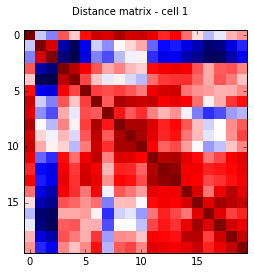

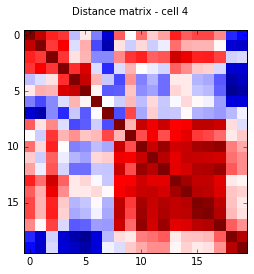

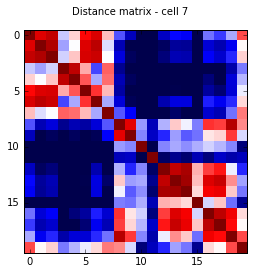

In [91]:
for ind in [1,4,7]:
    plt.suptitle('Distance matrix - cell '+str(ind))
    plt.imshow(-mats[ind],interpolation='nearest',cmap='seismic',vmin=-1000,vmax=0)
    plt.show()